# Unit 5 - Financial Planning

In [14]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [15]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [16]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3


In [17]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [18]:
# Fetch current BTC price
my_btc_response = requests.get(btc_url)
response_content = my_btc_response.content
b = json.loads(response_content)
btc_price = b['data']["1"]['quotes']['USD']['price']


# Fetch current ETH price
my_eth_response = requests.get(eth_url)
response_content = my_eth_response.content
e = json.loads(response_content)
eth_price = e['data']["1027"]['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $53979.60
The current value of your 5.3 ETH is $16586.56


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [19]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [20]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [21]:
# Format current date as ISO format
today = pd.Timestamp("2021-09-10", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
ticker_data = api.get_barset(
    tickers,
    timeframe,
    start = today,
    end = today,
    limit = 1000
).df

# Preview DataFrame
ticker_data.head()

AGG                                        SPY  \
                             open    high       low   close   volume    open   
time                                                                           
2021-09-10 00:00:00-04:00  115.99  116.01  115.7801  115.87  2767552  451.04   

                                                            
                             high     low  close    volume  
time                                                        
2021-09-10 00:00:00-04:00  451.49  445.31  445.5  75763259

In [22]:
# Pick AGG and SPY close prices
agg_close_price = float(ticker_data["AGG"]["close"])
spy_close_price = float(ticker_data["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $115.87
Current SPY closing price: $445.5


In [23]:
# Compute the current value of shares
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22275.00
The current value of your 200 AGG shares is $23174.00


### Savings Health Analysis

In [24]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
share = my_spy_value + my_agg_value
crypto = my_btc_value + my_eth_value

# Create savings DataFrame
#base = {'crypto': str(crypto), 'share': str(share)}
base = {'asset_type': ['share', 'crypto'], 'amount': [share, crypto]}
df_savings = pd.DataFrame(data=base)
df_savings = df_savings.set_index('asset_type')
# Display savings DataFrame
display(df_savings)

,amount
asset_type,
share,45449.000
crypto,70566.162


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021582CFFA08>],
      dtype=object)

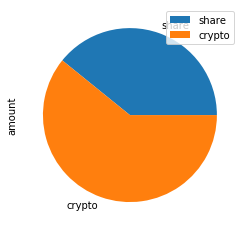

In [25]:
# Plot savings pie chart
df_savings.plot.pie(subplots=True)

In [26]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
df_savings_total = df_savings.sum()
#df_savings_total
# Validate saving health
if float(df_savings_total) > float(emergency_fund):
    print(f"Congratulations, you for having enough money in this fund.")
elif float(df_savings_total) <= float(emergency_fund):
    print(f"You need more money in this fund.")
else:
    print("Make everyday your most useful day.")

Congratulations, you for having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [27]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [28]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = 1000
).df

# Display sample data
df_stock_data.head()

AGG                                         \
                             open     high       low    close     volume   
time                                                                       
2017-05-10 00:00:00-04:00  108.60  108.660  108.4400  108.520  1427511.0   
2017-05-11 00:00:00-04:00  108.35  108.540  108.3435  108.515  1773499.0   
2017-05-12 00:00:00-04:00  108.81  108.940  108.7800  108.920  1136553.0   
2017-05-15 00:00:00-04:00  108.85  108.940  108.8200  108.890  1620264.0   
2017-05-16 00:00:00-04:00  108.88  109.101  108.8800  109.000  1394153.0   

                              SPY                                       
                             open    high     low    close      volume  
time                                                                    
2017-05-10 00:00:00-04:00     NaN     NaN     NaN      NaN         NaN  
2017-05-11 00:00:00-04:00  239.35  239.57  238.13  239.410  45435690.0  
2017-05-12 00:00:00-04:00  239.09  239.21  238.67  239.030  35283567.0  
2017-05-15 00:00:00-04:00  239.47  240.44  239.45  240.245  42230620.0  
2017-05-16 00:00:00-04:00  240.62  240.67  239.63  240.100  37206183.0

In [29]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30y_cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [30]:
# Printing the simulation input data
MC_30y_cr.portfolio_data.head()

AGG                                         \
                             open     high       low    close     volume   
time                                                                       
2017-05-10 00:00:00-04:00  108.60  108.660  108.4400  108.520  1427511.0   
2017-05-11 00:00:00-04:00  108.35  108.540  108.3435  108.515  1773499.0   
2017-05-12 00:00:00-04:00  108.81  108.940  108.7800  108.920  1136553.0   
2017-05-15 00:00:00-04:00  108.85  108.940  108.8200  108.890  1620264.0   
2017-05-16 00:00:00-04:00  108.88  109.101  108.8800  109.000  1394153.0   

                                           SPY                           \
                          daily_return    open    high     low    close   
time                                                                      
2017-05-10 00:00:00-04:00          NaN     NaN     NaN     NaN      NaN   
2017-05-11 00:00:00-04:00    -0.000046  239.35  239.57  238.13  239.410   
2017-05-12 00:00:00-04:00     0.003732  239.09  239.21  238.67  239.030   
2017-05-15 00:00:00-04:00    -0.000275  239.47  240.44  239.45  240.245   
2017-05-16 00:00:00-04:00     0.001010  240.62  240.67  239.63  240.100   

                                                    
                               volume daily_return  
time                                                
2017-05-10 00:00:00-04:00         NaN          NaN  
2017-05-11 00:00:00-04:00  45435690.0          NaN  
2017-05-12 00:00:00-04:00  35283567.0    -0.001587  
2017-05-15 00:00:00-04:00  42230620.0     0.005083  
2017-05-16 00:00:00-04:00  37206183.0    -0.000604

In [31]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30y_cr.summarize_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

count           500.000000
mean             22.605871
std              16.778132
min               1.991904
25%              10.684501
50%              17.735955
75%              29.246928
max             106.287449
95% CI Lower      4.409174
95% CI Upper     66.257503
Name: 7560, dtype: float64

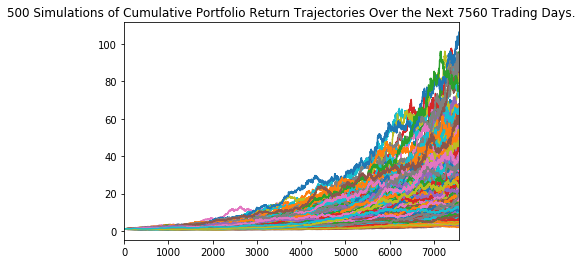

In [32]:
# Plot simulation outcomes
line_plot = MC_30y_cr.plot_simulation()

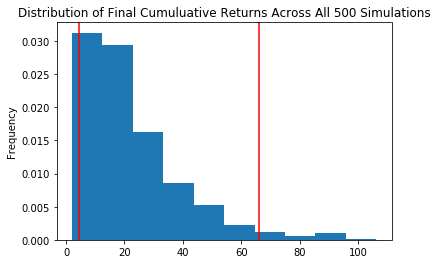

In [33]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30y_cr.plot_distribution()

### Retirement Analysis

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_tbl = MC_30y_cr.summarize_cumulative_return()

# Print summary statistics
print(summary_tbl)

count           500.000000
mean             22.605871
std              16.778132
min               1.991904
25%              10.684501
50%              17.735955
75%              29.246928
max             106.287449
95% CI Lower      4.409174
95% CI Upper     66.257503
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [35]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_tbl[8]*initial_investment,2)
ci_upper = round(summary_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $88183.48 and $1325150.05


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [36]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_tbl[8]*initial_investment,2)
ci_upper = round(summary_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $132275.23 and $1987725.08


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [37]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5y_cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.3,0.7],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [38]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5y_cr.summarize_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

count           500.000000
mean              1.781515
std               0.551434
min               0.693845
25%               1.391513
50%               1.694458
75%               2.090355
max               4.436597
95% CI Lower      0.980429
95% CI Upper      3.074270
Name: 1260, dtype: float64

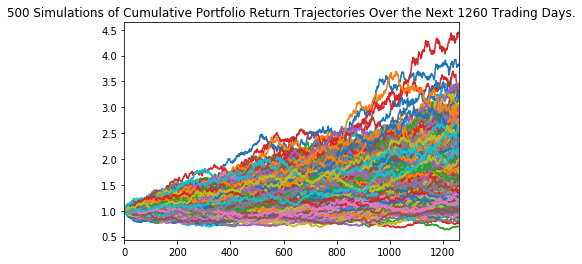

In [39]:
# Plot simulation outcomes
line_plot = MC_5y_cr.plot_simulation()

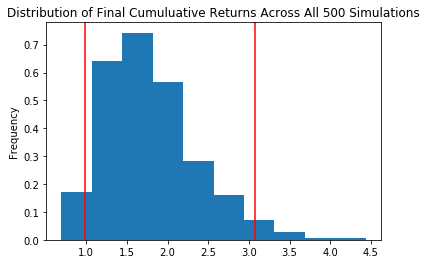

In [40]:
# Plot probability distribution and confidence intervals
dist_plot = MC_5y_cr.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5_tbl = MC_5y_cr.summarize_cumulative_return()

# Print summary statistics
print(summary_5_tbl)

count           500.000000
mean              1.781515
std               0.551434
min               0.693845
25%               1.391513
50%               1.694458
75%               2.090355
max               4.436597
95% CI Lower      0.980429
95% CI Upper      3.074270
Name: 1260, dtype: float64


In [42]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_5_tbl[8]*initial_investment,2)
ci_upper_five = round(summary_5_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $58825.74 and $184456.22


### Ten Years Retirement Option

In [43]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y_cr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.3,0.7],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [44]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10y_cr.summarize_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

count           500.000000
mean              3.200158
std               1.565818
min               0.877278
25%               2.142218
50%               2.821207
75%               3.995307
max              16.464413
95% CI Lower      1.222658
95% CI Upper      6.498475
Name: 2520, dtype: float64

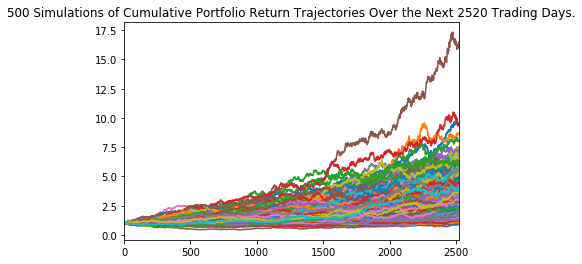

In [45]:
# Plot simulation outcomes
line_plot = MC_10y_cr.plot_simulation()

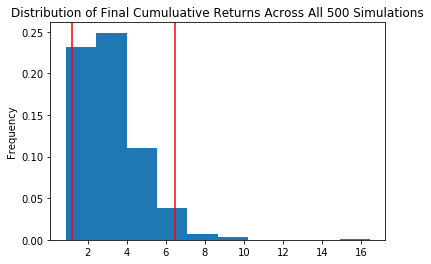

In [46]:
# Plot probability distribution and confidence intervals
dist_plot = MC_10y_cr.plot_distribution()

In [47]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10_tbl = MC_10y_cr.summarize_cumulative_return()

# Print summary statistics
print(summary_10_tbl)

count           500.000000
mean              3.200158
std               1.565818
min               0.877278
25%               2.142218
50%               2.821207
75%               3.995307
max              16.464413
95% CI Lower      1.222658
95% CI Upper      6.498475
Name: 2520, dtype: float64


In [280]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_10_tbl[8]*initial_investment,2)
ci_upper_ten = round(summary_10_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $73357.45 and $438663.75
